In [1]:
from matplotlib.collections import PathCollection
import cv2 as cv
import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic_2d, pearsonr
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba

import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
import scipy.io as sio
from scipy.interpolate import CubicSpline
from sklearn.cluster import AgglomerativeClustering
import umap
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec, transforms
from scipy.special import factorial
import pickle
import glob
import re
import os
#from utils_tda import *
gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
#    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)

    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1

    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)

    f = lsmr(Aw, Bw)[0]%1
    return f, verts

def get_coords_ds(rips_real, len_indstemp, ph_classes = [0,1], dec_thresh = 0.99, coeff = 47):
    num_circ = len(ph_classes)    
    ################### Decode coordinates ####################
    diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
    cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
    dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
    births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
    deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
    deaths1[np.isinf(deaths1)] = 0
    lives1 = deaths1-births1 # the lifetime for the 1-dim classes
    iMax = np.argsort(lives1)
    coords1 = np.zeros((num_circ, len_indstemp))
    for j,c in enumerate(ph_classes):
        cocycle = cocycles[iMax[-(c+1)]]
        threshold = births1[iMax[-(c+1)]] + (deaths1[iMax[-(c+1)]] - births1[iMax[-(c+1)]])*dec_thresh
        coordstemp,inds = get_coords(cocycle, threshold, len_indstemp, dists_land, coeff)
        coords1[j,inds] = coordstemp
    return coords1

def get_coords_all(sspikes2, coords1, times_cube, indstemp, dim = 7, spk2 = [], bPred = False, bPCA = False):
    num_circ = len(coords1)
    spkmean = np.mean(sspikes2[times_cube,:], axis = 0)
    spkstd = np.std(sspikes2[times_cube,:], axis = 0)
    spkscale = (sspikes2-spkmean)/spkstd
    dspk1 = spkscale.copy()
    if bPCA:
        __, e1, e2,__ = pca(spkscale[times_cube,:], dim = dim)
        dspk1 = np.dot(e1.T, spkscale.T).T    
        dspk1 /= np.sqrt(e2)    
        
    dspk = dspk1[indstemp,:]
    if len(spk2)>0:
        dspk1 = (spk2-spkmean)/spkstd
        if bPCA:
            dspk1 = np.dot(e1.T, dspk1.T).T    
            dspk1 /= np.sqrt(e2)    


    if bPred:
        coords_mod1 = np.zeros((len(dspk1), num_circ))
        coords_mod1[:,0] = predict_color(coords1[0,:], dspk1, dspk, 
                                     dist_measure='cosine',  k = 30)
        coords_mod1[:,1] = predict_color(coords1[1,:],  dspk1, dspk,
                                         dist_measure='cosine',  k = 30)
    else:
        num_neurons = len(dspk[0,:])
        centcosall = np.zeros((num_neurons, num_circ, len(indstemp)))
        centsinall = np.zeros((num_neurons, num_circ, len(indstemp)))    
        for neurid in range(num_neurons):
            spktemp = dspk[:, neurid].copy()
            centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
            centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

        a = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coords_mod1 = np.arctan2(mtot2,mtot1)%(2*np.pi)
    return coords_mod1

def get_cross(sspikes, mouse_sess, lencorr = 10, data_dir = 'place_data', bload = False):
    if bload:
        crosscorrfile = glob.glob(data_dir + '/' + mouse_sess + '_crosscorrs.npz')
        f = np.load(crosscorrfile[0], allow_pickle = True)
        crosscorrs = f['crosscorrs'][()]
        f.close()
    else:
        lenspk, num_neurons = np.shape(sspikes)
        crosscorrs = np.zeros((len(sspikes[0,:]), len(sspikes[0,:]), lencorr*2+1))
        spksum = np.sum(sspikes,0)
        spksum_all = np.zeros((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                spksum_all[i,j] = spksum[j]*spksum[i]
        times_all = {}
        
        for it, t1 in enumerate(np.arange(-lencorr, lencorr+1)):
            times_all[it] = np.arange(0,lenspk)+t1+lencorr
            
        for i in range(num_neurons):
            spktemp = np.concatenate((np.zeros(lencorr), sspikes[:,i], np.zeros(lencorr)))
            for j in range(i+1, num_neurons):
                for it in times_all:
                    crosscorrs[i,j,it] = np.dot(sspikes[:,j],spktemp[times_all[it]])/spksum_all[i,j]       
#                print(crosscorrs[i,j,:])
        np.savez(data_dir + '/' + mouse_sess + '_crosscorrs', crosscorrs = crosscorrs)
    return crosscorrs


def get_crossmat(crosscorr_train, lenspk, lencorr = -1):
    num_neurons = len(crosscorr_train)
    crosscorrs = np.zeros((num_neurons,num_neurons))
    num_neurons = len(crosscorr_train[:,0,0])
    lenorig = int(len(crosscorr_train[0,0,:])/2)
    if lencorr==-1:
        lencorr = lenorig
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            c = crosscorr_train[i,j,lenorig-lencorr:lenorig+lencorr+1].copy()*lenspk
#            print(c)

#            c = crosscorr_train[i,j,:].copy()*lenspk
            if np.min(c)>0:
                crosscorrs[i,j] +=  1-np.exp(-np.square(np.min(c)/np.max(c)))
                #crosscorrs[i,j] +=  1/(np.max(c)-np.min(c))#np.mean(np.exp(-np.square(c)))#-np.min(c))#np.exp(-np.sum(c))#-np.min(c)
            crosscorrs[j,i] = crosscorrs[i,j]
    print(np.unique(crosscorrs))
    crosscorrs[np.isnan(crosscorrs)] = 1
    crosscorrs[np.isinf(crosscorrs)] = 1
    return crosscorrs


def get_dgms(sspikes2, maxdim = 1, omega = 1, k  = 1000, 
    n_points = 800, dim = 7, nbs = 800, eps = 1, metric = 'cosine', 
             indstemp = [],movetimes1 = []):    
    dgms_all = {}
    dim_red_spikes_move_scaled = preprocessing.scale(sspikes2, axis = 0)
        
    if dim > 0:
        dim_red_spikes_move_scaled, e1, e2, var_exp = pca(dim_red_spikes_move_scaled, dim = dim)
        dim_red_spikes_move_scaled /= np.sqrt(e2[:dim])  
    else:
        var_exp = 0
    if len(indstemp)==0:
        if len(movetimes1) == 0:
            startindex = np.argmax(np.sum(np.abs(dim_red_spikes_move_scaled),1))
            if eps > 0:
                movetimes1 = radial_downsampling(dim_red_spikes_move_scaled, metric = 'euclidean', epsilon = eps, 
                    startindex = startindex)
            else:
                movetimes1 = np.arange(len(dim_red_spikes_move_scaled))
        if n_points> len(movetimes1):
            indstemp = movetimes1.copy()
        else:
        
            indstemp,__  = sample_denoising(dim_red_spikes_move_scaled[movetimes1,:],  k, 
                                               n_points, omega, metric)
            indstemp = movetimes1[indstemp]
    dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
    X = squareform(pdist(dim_red_spikes_move_scaled[:,:], metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)
    thresh = np.max(d[~np.isinf(d)])
    if maxdim == 2:
        hom_dims = list(range(maxdim+1))
        VR = VietorisRipsPersistence(
        homology_dimensions=hom_dims,
        metric='precomputed',
        coeff=47,
        max_edge_length= thresh,
        collapse_edges=False,  # True faster?
        n_jobs=None  # -1 faster?
        )
        diagrams = VR.fit_transform([d])
        dgms_all[0] = from_giotto_to_ripser(diagrams[0])
        persistence = []
    else:
        persistence = ripser(d, maxdim=1, coeff=47, do_cocycles= True, distance_matrix = True, thresh = thresh)    
        dgms_all[0] = persistence['dgms'] 
    return dgms_all, persistence, indstemp, movetimes1, var_exp

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]),0)

    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0][0])
        for i in np.arange(1, num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][0][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (3,5), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 3)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 3)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig


def pca(data, dim=2):
    if dim < 1:
        return data, [0]
    m, n = data.shape
    # mean center the data
    # data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dim]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors

    tot = np.sum(evals)
    var_exp = [(i / tot) * 100 for i in sorted(evals[:], reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    components = np.dot(evecs.T, data.T).T
    return components, evecs, evals[:dim], var_exp
@numba.njit(parallel=True, fastmath=True)
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho
def sample_denoising(data,  k = 10, num_sample = 500, omega = 1, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)

    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)

    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    print(np.mean(F),np.median(F))
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = []
    j = 0
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[inds_left][Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds.extend([i])
    return inds, Fs

def load_data(session):
    ff = glob.glob('Data/' + session + '_25.npz')
    if len(ff)>0:
        f = np.load(ff[0], allow_pickle = True)
        ccg = f['ccg'] 
        spikes_bin = f['spikes_bin'][()]
        hdd = f['hdd']
        xx = f['xx']
        yy = f['yy']    
        ind = f['ind']
        f.close()
    else:
        data_path = 'Data/' + session + '/'
        f = np.load(data_path + 'data.npz', allow_pickle = True)
        data = f['data'][()]
        f.close()        
        angle_list_orig = np.array(read_numerical_file('Data/' + session + '/' + session + '.ang', 'float', 'multiple'))
        angle_list = np.array(angle_list_orig[:,1])
        angle_list[angle_list < -0.5] = np.nan
        angle_times  =angle_list_orig[:,0]
        data['angle_list'] = angle_list
        data['angle_times'] = angle_times
        spike_times =data['spike_times']
        hd = data['angle_list']
        samp_rate = data['pos_sampling_rate']

        area_info = load_pickle_file('Data/area_shank_info.p')
        relevant_shanks = area_info[session]['ADn']
        spike_times1 = {}
        spikes_bin = {}
        
        it = 0
        for spk in spike_times:
            numspk = sum((spike_times[spk]>=data['state_times']['Wake'][0][0]) & 
                   (spike_times[spk]<=data['state_times']['Wake'][0][1]))
            lensess = data['state_times']['Wake'][0][1]-data['state_times']['Wake'][0][0]
            fr = numspk/lensess
    #        if spk[0] in relevant_shanks:
            if (fr>=0.05) | (fr<10):
                spike_times1[it] = spike_times[spk]
                it += 1
            else:
                print('fr ', fr)
            
        for brain_state in ['Wake', 'REM', 'SWS']:
            t_curr =  data['state_times'][brain_state]
            res = 100000
            if brain_state == 'SWS':
                dt = 200000
                sigma = 5000
            else:
                dt = 25000
                sigma = 25000
            thresh = 250000
            num_thresh = int(thresh/dt)
            num2_thresh = int(2*num_thresh)
            sig2 = 1/(2*(sigma/res)**2)
            ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
            kerwhere = np.arange(-num_thresh,num_thresh)*dt

            spikes_bin_tmp = np.zeros((1,len(spike_times1)))
            for ttmp in t_curr:
                min_time = ttmp[0]*res
                max_time = ttmp[-1]*res
                tt = np.arange(np.floor(min_time), np.ceil(max_time)+1, dt)

                spikes_temp = np.zeros((len(tt)+num2_thresh, len(spike_times1)))
                for n, spk in enumerate(spike_times1):
                    spk = spike_times1[spk]
                    spikes = np.array(spk*res-min_time, dtype = int)
                    spikes = spikes[(spikes < (max_time-min_time)) & (spikes > 0)]
                    spikes_mod = dt-spikes%dt
                    spikes = np.array(spikes/dt, int)
                    for m, j in enumerate(spikes):
                        spikes_temp[j:j+num2_thresh, n] += ker[np.abs(kerwhere+spikes_mod[m])]
                spikes_temp = spikes_temp[num_thresh-1:-(num_thresh+1),:]
                spikes_bin_tmp = np.concatenate((spikes_bin_tmp, spikes_temp),0)
            spikes_bin[brain_state] = spikes_bin_tmp[1:,:]
            spikes_bin[brain_state] *= 1/np.sqrt(2*np.pi*(sigma/res)**2)
            if brain_state == 'Wake':
                pos_list_orig = np.array(read_numerical_file('Data/'+ session + '/' + session + '.pos', 'float', 'multiple'))
                t = pos_list_orig[:,0]
                x = pos_list_orig[:,1]
                y = pos_list_orig[:,2]
                tt/=res
                nnans = ~np.isnan(x)
                xspline = CubicSpline(t[nnans], x[nnans]) 
                nnans = ~np.isnan(y)
                yspline = CubicSpline(t[nnans], y[nnans]) 
                nnans = ~np.isnan(hd)
                hdsplinecos = CubicSpline(t[nnans], np.cos(hd[nnans]))
                hdsplinesin = CubicSpline(t[nnans], np.sin(hd[nnans]))
                xx = xspline(tt)
                yy = yspline(tt)
                hdd = np.arctan2(hdsplinesin(tt), hdsplinecos(tt))%(2*np.pi)   

        ccg = get_cross(session, data, spike_times1, data_dir = 'Data', spike_times = [], files = ['Wake', 'REM', 'SWS'])
        ind = get_ind(session, ccg, data_dir = 'Data', files = ['Wake', 'REM', 'SWS'], nbs = 0.6)

        np.savez('Data/' + session + '_25', ind = ind, ccg = ccg, spikes_bin = spikes_bin, hdd = hdd, xx = xx, yy = yy)
    return ind, ccg, spikes_bin, hdd, xx, yy

def get_ind(crosscorrs, nbs = -1, linkage = 'average'):
    ################### Get crosscorr stats ####################
    crosscorrs[np.isinf(crosscorrs)] = 2*np.max(crosscorrs[~np.isinf(crosscorrs)])
    agg = AgglomerativeClustering(n_clusters=None,affinity='precomputed', linkage=linkage, 
                                  distance_threshold=nbs)
    ind = agg.fit(crosscorrs).labels_
    
    fig = plt.figure()
    crosscorrs = crosscorrs[np.argsort(ind), :]
    crosscorrs = crosscorrs[:, np.argsort(ind)]    
    plt.imshow(crosscorrs)
    return ind

def radial_downsampling(data_in, epsilon = 0.1, metric = 'euclidean', startindex = -1):    
    n = data_in.shape[0]
    np.random.seed(0) 
    if epsilon > 0:
        n = data_in.shape[0]
        if startindex == -1:
            startindex = np.random.randint(n)
        i = startindex
        j = 1
        inds = np.zeros((n, ), dtype=int)
        inds1 = np.arange(n, dtype=int)
        dists = np.zeros((n, ))
        while j < n+1:
            disttemp = (cdist(data_in[i, :].reshape(1, -1), data_in[inds1, :], metric=metric) - epsilon)[0]                        
            dists[inds1] = np.max(np.concatenate((dists[inds1][:,np.newaxis], disttemp[:,np.newaxis]),1),1)
            inds[i] = j
            inds1 = inds1[disttemp>0]
            j = j+1
            if len(inds1)>0:
                i = inds1[np.argmin(dists[inds1])]
#                i = inds1[np.argmax(dists[inds1])]
#                i = inds1[np.argmax(disttemp[disttemp>0])]

            else:
                break
    else:
        inds = np.ones(range(np.shape(data_in)[0]))
    inds = np.where(inds)[0]
    return inds



def predict_color(circ_coord_sampled, data, sampled_data, dist_measure='euclidean', num_batch =20000, k = 10):
    num_tot = len(data)
#    zero_spikes = np.where(np.sum(data,1) == 0)[0]
#    if len(zero_spikes):
#       data[zero_spikes,:] += 1e-10 
    circ_coord_tot = np.zeros(num_tot)
    circ_coord_dist = np.zeros(num_tot)
    circ_coord_tmp = circ_coord_sampled*2*np.pi
    j = -1
    for j in range(int(num_tot/num_batch)):
        dist_landmarks = cdist(data[j*num_batch:(j+1)*num_batch, :], sampled_data, metric = dist_measure)
        closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
        weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,-1]] for i in range(num_batch)])
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 

        sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        circ_coord_tot[j*num_batch:(j+1)*num_batch] = np.arctan2(sincirc, coscirc)%(2*np.pi)

    dist_landmarks = cdist(data[(j+1)*num_batch:, :], sampled_data, metric = dist_measure)
    closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
    lenrest = len(closest_landmark[:,0])
    weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,k-1:k]] for i in range(lenrest)])
    if np.shape(weights)[0] == 0:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1 
        weights /= np.sum(weights)
    else:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 
    sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    circ_coord_tot[(j+1)*num_batch:] = np.arctan2(sincirc, coscirc)%(2*np.pi)
    return circ_coord_tot

def information_score(mtemp, circ, mu):
    numangsint = mtemp.shape[0]+1
    circ = np.ravel_multi_index(circ-1, np.shape(mtemp))
    mtemp = mtemp.flatten() 
    p = np.bincount(circ, minlength = (numangsint-1)**2)/len(circ)
    logtemp = np.log2(mtemp/mu)
    mtemp = np.multiply(np.multiply(mtemp,p), logtemp)
    return np.sum(mtemp[~np.isnan(mtemp)])
def circmean(x):
    return np.arctan2(np.mean(np.sin(x)), np.mean(np.cos(x)))


def smooth_tuning_map(mtot, numangsint, sig, bClose = True):
    numangsint_1 = numangsint-1
    mid = int((numangsint_1)/2)
    indstemp1 = np.zeros((numangsint_1,numangsint_1), dtype=int)
    indstemp1[indstemp1==0] = np.arange((numangsint_1)**2)
    indstemp1temp = indstemp1.copy()
    mid = int((numangsint_1)/2)
    mtemp1_3 = mtot.copy()
    for i in range(numangsint_1):
        mtemp1_3[i,:] = np.roll(mtemp1_3[i,:],int(i/2))
    mtot_out = np.zeros_like(mtot)
    mtemp1_4 = np.concatenate((mtemp1_3, mtemp1_3, mtemp1_3),1)
    mtemp1_5 = np.zeros_like(mtemp1_4)
    mtemp1_5[:, :mid] = mtemp1_4[:, (numangsint_1)*3-mid:]  
    mtemp1_5[:, mid:] = mtemp1_4[:,:(numangsint_1)*3-mid]      
    mtemp1_6 = np.concatenate((mtemp1_5,mtemp1_4,mtemp1_5)) 
    if bClose:
        nans = np.isnan(mtemp1_6)
        mtemp1_6[nans] = np.mean(mtemp1_6[~nans])
        mtemp1_6 = gaussian_filter(mtemp1_6,sigma = sig)
        mtemp1_6[nans] = np.nan
        radius = 1
        L = np.arange(-radius, radius + 1)
        X, Y = np.meshgrid(L, L)
        kernel = np.array((X ** 2 + Y ** 2) <= radius ** 2).astype(np.uint8)        
        mtemp1_6 = cv.morphologyEx(mtemp1_6, cv.MORPH_CLOSE, kernel, iterations = 1)
    else:
        mtemp1_6 = gaussian_filter(mtemp1_6, sigma = sig)
    for i in range(numangsint_1):
        mtot_out[i, :] = mtemp1_6[(numangsint_1)+i, 
                                          (numangsint_1) + (int(i/2) +1):(numangsint_1)*2 + (int(i/2) +1)] 
    return mtot_out



def plot_cumulative_stat(stat, stat_shuffle, stat_range, stat_scale, xs, ys, xlim, ylim):
    num_neurons = len(stat)
    num_shuffle = len(stat_shuffle)
    fig = plt.figure()
    ax = plt.axes()
    numbins = 30
    meantemp = np.zeros(numbins)
    stat_all = np.array([])
    mean_stat_all = np.zeros(num_shuffle)
    for i in range(num_shuffle):
        stat_all = np.concatenate((stat_all, stat_shuffle[i]))
        mean_stat_all[i] = np.mean(stat_shuffle[i])

    meantemp1 = np.histogram(stat_all, range = stat_range, bins = numbins)[0]
    meantemp = np.cumsum(meantemp1)
    meantemp = np.divide(meantemp, num_shuffle)
    meantemp = np.divide(meantemp, num_neurons)
    y,x = np.histogram(stat, range = stat_range, bins = numbins)
    y = np.cumsum(y)
    y = np.divide(y, num_neurons)
    x = x[1:]-(x[1]-x[0])/2
    x *= stat_scale
    ax.plot(x, meantemp, c ='k', ls = ':', alpha = 0.8, lw = 6)
    ax.plot(x,y, c = [0, 0.4,0.4],  alpha = 0.8, lw = 6)

    ax.set_xticks(xs)
    ax.set_xticklabels(np.zeros(len(xs),dtype=str))
    ax.xaxis.set_tick_params(width=1, length =5)
    ax.set_yticks(ys)
    ax.set_yticklabels(np.zeros(len(ys),dtype=str))
    ax.yaxis.set_tick_params(width=1, length =5)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()

    ax.set_aspect(abs(x1-x0)/(abs(y1-y0)*1.4))

    plt.gca().axes.spines['top'].set_visible(False)
    plt.gca().axes.spines['right'].set_visible(False)
def get_corr_dist(masscenters_1,masscenters_2, mtot_1, mtot_2, sig = 2.75, num_shuffle = 1000):
    numangsint = len(mtot_1[0,:,0])+1
    num_neurons = len(masscenters_1[:,0])
    cells_all = np.arange(num_neurons)
    corr = np.zeros(num_neurons)
    corr1 = np.zeros(num_neurons)
    corr2 = np.zeros(num_neurons)
    mtot_1_shuf = np.zeros_like(mtot_1)
    mtot_2_shuf = np.zeros_like(mtot_2)
    for n in cells_all:
        m1 = mtot_1[n,:,:].copy()
        m1[np.isnan(m1)] = np.min(m1[~np.isnan(m1)])
        m2 = mtot_2[n,:,:].copy()
        m2[np.isnan(m2)] = np.min(m2[~np.isnan(m2)])
        m1 = smooth_tuning_map(m1, numangsint, sig, bClose = False)
        m2 = smooth_tuning_map(m2, numangsint, sig, bClose = False)
        corr[n] = pearsonr(m1.flatten(), m2.flatten())[0]
        mtot_1_shuf[n,:,:]= m1
        mtot_2_shuf[n,:,:]= m2

    dist =  np.sqrt(np.sum(np.square(np.arctan2(np.sin(masscenters_1 - masscenters_2),
                                  np.cos(masscenters_1 - masscenters_2))),1))
    dist_shuffle = np.zeros((num_shuffle, num_neurons))
    corr_shuffle = np.zeros((num_shuffle, num_neurons))
    np.random.seed(47)
    for i in range(num_shuffle):
        inds = np.arange(num_neurons)
        np.random.shuffle(inds)
        for n in cells_all:
            corr_shuffle[i,n] = pearsonr(mtot_1_shuf[n,:,:].flatten(), mtot_2_shuf[inds[n],:,:].flatten())[0]
        dist_shuffle[i,:] =  np.sqrt(np.sum(np.square(np.arctan2(np.sin(masscenters_1 - masscenters_2[inds,:]),
                np.cos(masscenters_1 - masscenters_2[inds,:]))),1))
    return corr, dist, corr_shuffle, dist_shuffle

          

def plot_phase_distribution(masscenters_1, masscenters_2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.axis('off')
    num_neurons = len(masscenters_1[:,0])
    for i in np.arange(num_neurons):
        ax.scatter(masscenters_1[i,0], masscenters_1[i,1], s = 10, c = 'r')
        if len(masscenters_2)>0:
            ax.scatter(masscenters_2[i,0], masscenters_2[i,1], s = 10, c ='k')
            line = masscenters_1[i,:] - masscenters_2[i,:]
            dline = line[1]/line[0]
            if line[0]< - np.pi and line[1] < -np.pi:
                line = (-2*np.pi + masscenters_2[i,:]) - masscenters_1[i,:]
                dline = line[1]/line[0]
                if (masscenters_1[i,1] + (- masscenters_1[i,0])*dline)>0:
                    ax.plot([masscenters_1[i,0], 0],
                            [masscenters_1[i,1], masscenters_1[i,1] + (- masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi,2*np.pi + -(masscenters_1[i,1] + (- masscenters_1[i,0])*dline)/dline], 
                            [masscenters_1[i,1] + (- masscenters_1[i,0])*dline, 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi + -(masscenters_1[i,1] + (- masscenters_1[i,0])*dline)/dline, 
                             masscenters_2[i,0]], 
                            [2*np.pi,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
                else:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (- masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (- masscenters_1[i,1])/dline, 0],
                            [2*np.pi, 2*np.pi + -(masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline], 
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, 
                             masscenters_2[i,0]], 
                            [2*np.pi + -(masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline,
                            masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
            elif line[0]> np.pi and line[1] >np.pi:
                line = (2*np.pi + masscenters_2[i,:]) - masscenters_1[i,:]
                dline = line[1]/line[0]
                if (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline)<2*np.pi:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline],

                           [masscenters_1[i,1],2*np.pi],
                           c = 'k', lw = 1, alpha = 0.5)
                    ax.plot([masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline, 2*np.pi],
                           [0,(2*np.pi - (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline))*dline], 
                           c = 'k', lw = 1, alpha = 0.5)
                    ax.plot([0,masscenters_2[i,0]],
                           [(2*np.pi - (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline))*dline, 
                            masscenters_2[i,1]], 
                           c = 'k', lw = 1, alpha = 0.5)          
                else:
                    ax.plot([masscenters_1[i,0],2*np.pi],
                            [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0,(2*np.pi - (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([(2*np.pi - (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [0,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)#
            elif line[0]>np.pi and line[1] <-np.pi:  
                line = [2*np.pi + masscenters_2[i,0], -2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]            
                if (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline)>0:
                    ax.plot([masscenters_1[i,0],2*np.pi],
                            [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0,(-(masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([(-(masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [2*np.pi,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)

                else:
                    line = [2*np.pi + masscenters_2[i,0], -2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                    dline = line[1]/line[0]
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (- masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (- masscenters_1[i,1])/dline, 2*np.pi], 
                            [2*np.pi, 2*np.pi + (2*np.pi- masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0, masscenters_2[i,0]], 
                            [2*np.pi + (2*np.pi- masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
            elif line[0]<-np.pi and line[1] >np.pi:
                line = [-2*np.pi + masscenters_2[i,0], 2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]
                if ((masscenters_1[i,1] + -(masscenters_1[i,0])*dline)<2*np.pi):

                    ax.plot([masscenters_1[i,0],0],
                            [masscenters_1[i,1], masscenters_1[i,1] + -(masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, 2*np.pi + (2*np.pi - (masscenters_1[i,1] + -(masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + -(masscenters_1[i,0])*dline, 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi + (2*np.pi - (masscenters_1[i,1] + -(masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [0,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
                else:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline, 0], 
                            [0, 0 + -(masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline)*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, masscenters_2[i,0]], 
                            [0 + -(masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline)*dline,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)

            elif line[0]< -np.pi:
                line = [(2*np.pi + masscenters_1[i,0]), masscenters_1[i,1]] - masscenters_2[i,:]
                dline = line[1]/line[0]
                ax.plot([masscenters_2[i,0],2*np.pi],
                        [masscenters_2[i,1], masscenters_2[i,1] + (2*np.pi - masscenters_2[i,0])*dline], 
                        alpha = 0.5, c = 'k', lw = 1)            
                ax.plot([0,masscenters_1[i,0]],
                        [masscenters_2[i,1] + (2*np.pi - masscenters_2[i,0])*dline, masscenters_1[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[0]> np.pi:
                line = [ masscenters_2[i,0]+ 2*np.pi, masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]


                ax.plot([masscenters_1[i,0],2*np.pi],
                        [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                        c = 'k', lw = 1, alpha = 0.5)
                ax.plot([0,masscenters_2[i,0]],
                        [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[1]< -np.pi:
                line = [ masscenters_1[i,0], (2*np.pi + masscenters_1[i,1])] - masscenters_2[i,:]
                dline = line[1]/line[0]

                ax.plot([masscenters_2[i,0], masscenters_2[i,0] + (2*np.pi - masscenters_2[i,1])/dline], 
                        [masscenters_2[i,1],2*np.pi], alpha = 0.5, c = 'k', lw = 1),
                ax.plot([masscenters_1[i,0] - masscenters_1[i,1]/dline,masscenters_1[i,0]],
                        [0, masscenters_1[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[1]> np.pi:
                line = [ masscenters_2[i,0], masscenters_2[i,1]+ 2*np.pi] - masscenters_1[i,:]
                dline = line[1]/line[0]

                ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline], 
                        [masscenters_1[i,1], 2*np.pi], alpha = 0.5, c = 'k', lw = 1),

                ax.plot([masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline,masscenters_2[i,0]],
                        [0, masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            else:
                ax.plot([masscenters_1[i,0],masscenters_2[i,0]],
                        [masscenters_1[i,1],masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)

    ax.plot([0,0], [0,2*np.pi], c = 'k')
    ax.plot([0,2*np.pi], [0,0], c = 'k')
    ax.plot([2*np.pi,2*np.pi], [0,2*np.pi], c = 'k')
    ax.plot([0,2*np.pi], [2*np.pi,2*np.pi], c = 'k')

    r_box = transforms.Affine2D().skew_deg(15,15)
    for x in ax.images + ax.lines + ax.collections + ax.get_xticklabels() + ax.get_yticklabels():
        trans = x.get_transform()
        x.set_transform(r_box+trans) 
        if isinstance(x, PathCollection):
            transoff = x.get_offset_transform()
            x._transOffset = r_box+transoff 
    ax.set_xlim([0,2*np.pi + 3/5*np.pi])
    ax.set_ylim([0,2*np.pi + 3/5*np.pi])
    ax.set_aspect('equal', 'box')
    return ax




In [2]:
import pandas as pd
pd.set_option('display.max_rows', 10)

#AngularRate = pd.read_pickle('functional/AngularRate')
AngularRate_Stats = pd.read_pickle('functional/AngularRate_Stats')
#Animal = pd.read_pickle('functional/Animal')
#ArenaObjectPos = pd.read_pickle('functional/ArenaObjectPos')
BorderScore = pd.read_pickle('functional/BorderScore')
BVScore = pd.read_pickle('functional/BVScore')
#Session_CueCard = pd.read_pickle('functional/Session_CueCard')
#Session_Intervention = pd.read_pickle('functional/Session_Intervention')
#Session_SessionType = pd.read_pickle('functional/Session_SessionType')
#Session_ArenaObject = pd.read_pickle('functional/Session_ArenaObject')
#Session_Apparatus = pd.read_pickle('functional/Session_Apparatus')
#Session_Data = pd.read_pickle('functional/Session_Data')
Session = pd.read_pickle('functional/Session')

GridScore = pd.read_pickle('functional/GridScore')
GridScore_Stats = pd.read_pickle('functional/GridScore_Stats')
NumberCellTypes_MEC = pd.read_pickle('functional/NumberCellTypes_MEC')
NumberCellTypes_PAS = pd.read_pickle('functional/NumberCellTypes_PAS')
Tracking_Linear = pd.read_pickle('functional/Tracking_Linear')
Tracking_OpenField = pd.read_pickle('functional/Tracking_OpenField')
#TrackingRaw = pd.read_pickle('functional/TrackingRaw')
OVCScore = pd.read_pickle('functional/OVCScores')
MECcells = pd.read_pickle('functional/MECcells')
PAScells = pd.read_pickle('functional/PAScells')
#PRHcells = pd.read_pickle('functional/PRHcells')
#RSAcells = pd.read_pickle('functional/RSAcells')
#Undefinedcells = pd.read_pickle('functional/Undefinedcells')
#CellRois = pd.read_pickle('functional/Cell_Rois')
FilteredCells = pd.read_pickle('functional/FilteredCells')
FilteredSpikes = pd.read_pickle('functional/FilteredSpikes')


In [3]:
sess_name0= '1f20835f09e28706'
spikes0 = []
it = 0
for i in FilteredSpikes[FilteredSpikes['session_name'] == sess_name0]['filtered_spikes']:
    spikes0.append(i)
    it += 1
spikes0 = np.array(spikes0)

In [4]:
sess_name1= '26fd0fbe1e205255'
spikes1 = []
it = 0
for i in FilteredSpikes[FilteredSpikes['session_name'] == sess_name1]['filtered_spikes']:
    spikes1.append(i)
    it += 1
spikes1 = np.array(spikes1)

In [5]:
cell_id = np.array(FilteredSpikes[FilteredSpikes['session_name'] == sess_name0]['cell_id'])
MEC_cellids = np.array(MECcells[MECcells['session_name']==sess_name0]['cell_id'])
filtered_cellids = np.array(FilteredCells[FilteredCells['session_name']==sess_name0]['cell_id'])
gs_id = np.array(GridScore[(GridScore['session_name'] == sess_name0) &
          #(GridScore['cell_id'] == i) &
          (GridScore['signal_type'] == 'spikes') & 
          (GridScore['map_params_id'] == 'B')
         ]['cell_id'])
del FilteredSpikes

In [6]:
gs_id = np.array(GridScore[(GridScore['session_name'] == sess_name0) &
          #(GridScore['cell_id'] == i) &
          (GridScore['signal_type'] == 'spikes') & 
          (GridScore['map_params_id'] == 'B')
         ]['cell_id'])

In [7]:
MEC_bool = np.zeros(len(cell_id), dtype = bool)
for it, i in enumerate(cell_id):
    MEC_bool[it] = i in MEC_cellids
filtered_bool = np.zeros(len(cell_id), dtype = bool)
for it, i in enumerate(cell_id):
    filtered_bool[it] = i in filtered_cellids
gs_bool = np.zeros(len(cell_id), dtype = bool)
for it, i in enumerate(cell_id):
    gs_bool[it] = i in gs_id

In [8]:
xx0, yy0, speed0, hd0, tt0 = [], [], [], [], []
for i in Tracking_OpenField[Tracking_OpenField['session_name'] == sess_name0]['x_pos']:
    xx0.extend([i])
xx0 = np.array(xx0[0])
for i in Tracking_OpenField[Tracking_OpenField['session_name'] == sess_name0]['y_pos']:
    yy0.extend([i])
yy0 = np.array(yy0[0])
for i in Tracking_OpenField[Tracking_OpenField['session_name'] == sess_name0]['speed']:
    speed0.extend([i])
speed0 = np.array(speed0[0])
for i in Tracking_OpenField[Tracking_OpenField['session_name'] == sess_name0]['head_angle']:
    hd0.extend([i])
hd0 = np.array(hd0[0])
for i in Tracking_OpenField[Tracking_OpenField['session_name'] == sess_name0]['timestamps']:
    tt0.extend([i])
tt0 = np.array(tt0[0])


In [9]:
pos, pos1, pos2, speed, hd, tt = [], [], [], [], [], []
for i in Tracking_Linear[Tracking_Linear['session_name'] == sess_name1]['pos']:
    pos.extend([i])
pos = np.array(pos[0])    
for i in Tracking_Linear[Tracking_Linear['session_name'] == sess_name1]['lap_pos']:
    pos1.extend([i])
pos1 = np.array(pos1[0])    

for i in Tracking_Linear[Tracking_Linear['session_name'] == sess_name1]['rel_pos']:
    pos2.extend([i])
pos2 = np.array(pos2[0])    


for i in Tracking_Linear[Tracking_Linear['session_name'] == sess_name1]['speed']:
    speed.extend([i])
speed = np.array(speed[0])

for i in Tracking_Linear[Tracking_Linear['session_name'] == sess_name1]['timestamps']:
    tt.extend([i])
tt = np.array(tt[0])


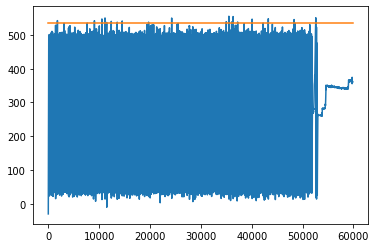

In [10]:
plt.plot(pos1)
plt.plot([0,len(pos1)], [534,534])

In [11]:
bs  = np.array(BorderScore[((BorderScore['session_name'] == sess_name0) &
                            (BorderScore['signal_type'] == 'spikes') &
                            (BorderScore['map_params_id'] == 'A'))]['borderscore'])

bvs =np.array(BVScore[((BVScore['session_name'] == sess_name0) &
                          (BVScore['signal_type'] == 'spikes') & 
                          (BVScore['map_params_id'] == 'A') & 
                      (BVScore['bv_field_dect_method'] == 'bvs'))]['bvs'])

hds = np.array(AngularRate_Stats[((AngularRate_Stats['session_name'] == sess_name0) &
                          (AngularRate_Stats['signal_type'] == 'spikes'))]['mvl'])

gs = np.zeros(len(cell_id))
gs[gs_bool]  = np.array(GridScore[((GridScore['session_name'] == sess_name0) &
                            (GridScore['signal_type'] == 'spikes') &
                            (GridScore['map_params_id'] == 'B'))]['gridscore'])

#gs_ori = np.zeros(len(cell_id))
#gs_ori[gs_bool] = np.array(GridScore_Stats[(GridScore_Stats['session_name'] == sess_name0) &
#                (GridScore_Stats['signal_type'] == 'spikes') & 
#                (GridScore_Stats['map_params_id'] == 'B')]['gs_orientation'])

#gs_spacing = np.zeros(len(cell_id))
#gs_spacing[gs_bool] = np.array(GridScore_Stats[(GridScore_Stats['session_name'] == sess_name0) &
#                (GridScore_Stats['signal_type'] == 'spikes') & 
#                (GridScore_Stats['map_params_id'] == 'B')]['gs_spacing'])

[  1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   3   3   3
   4   4   4   4   5   8  10  10  11  12 113]
0 8 -0.30481008638453294
1 10 0.44707813559015097
2 11 0.08278613286249419
3 2 0.12025534234269261
4 2 -0.12617522509459636
5 113 0.5235126647000171
6 4 0.12824118654453548
7 4 0.06472499893726788
8 2 0.07331894873764344
9 2 0.2044866772767692
10 10 0.17431876498086565
11 1 0.07892152315740418
12 4 -0.08075874643952594
13 3 -0.034607387248030884
14 1 -0.06590263984005335
15 5 -0.006365215581515589
16 1 -0.011990865588010985
17 1 0.9054965091950514
18 1 -0.29944420155161633
19 4 0.10898975266964103
20 1 -0.23377304730525783
21 2 0.042652914515186165
22 12 -0.0715399903769578
23 1 0.08782878592240832
24 1 0.2918638911952105
25 1 0.20591402988297655
26 3 0.13479895135693823
27 2 -0.015888520295343156
28 3 -0.10100662363690026


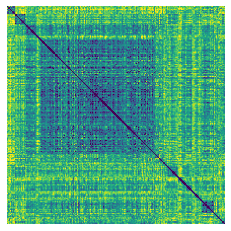

In [12]:
acorrs = np.array(GridScore[(GridScore['session_name'] == sess_name0) &
          (GridScore['signal_type'] == 'spikes') & 
          (GridScore['map_params_id'] == 'B')
         ]['acorr'])
acorrs_all = np.zeros((len(acorrs), len(acorrs[0])**2))
for i in range(len(acorrs)):
    acorrs_all[i,:] = acorrs[i].flatten()
MEC_bool = np.ones(len(filtered_bool), dtype = bool)
acorrs_all = acorrs_all[filtered_bool& gs_bool & MEC_bool,:]
thr = -np.inf
dd = squareform(pdist(preprocessing.scale(acorrs_all[:,:],axis = 1), metric = 'cityblock'))
#dd = squareform(pdist(acorrs_all[MEC_bool[filtered_bool & gs_bool],:], metric = 'correlation'))
dd = dd[gs[filtered_bool & gs_bool & MEC_bool]>thr, :]
dd = dd[:, gs[filtered_bool & gs_bool & MEC_bool]>thr]
#ind = get_ind(dd, nbs = 2000, linkage = 'average')

dd[np.isinf(dd)] = 2*np.max(dd[~np.isinf(dd)])
agg = AgglomerativeClustering(n_clusters=None,affinity='precomputed', linkage='average', 
                              distance_threshold=2000)
ind = agg.fit(dd).labels_

fig = plt.figure()
dd = dd[np.argsort(ind), :]
dd = dd[:, np.argsort(ind)]    
dd1 = np.sort(dd[np.triu_indices(dd.shape[0],1)])
plt.imshow(dd, vmin = dd1[int(0.01*len(dd1))], vmax = dd1[int(0.99*len(dd1))])
plt.axis('off')
plt.savefig('Figs/Functional/' + sess_name0 + '/acorr_dist.png', transparent = True)
plt.savefig('Figs/Functional/' + sess_name0 + '/acorr_dist.pdf', transparent = True)


print(np.sort(np.bincount(ind)))
for ii in np.unique(ind):
    print(ii, np.sum(ind==ii), np.median(gs[filtered_bool & gs_bool & MEC_bool][gs[filtered_bool & gs_bool & MEC_bool]>thr][ind==ii]))

0 8
85


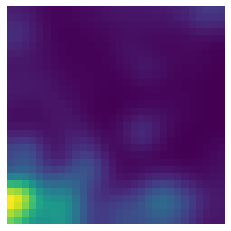

100


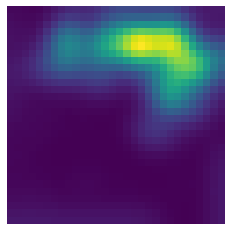

109


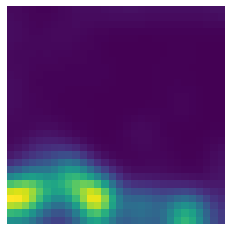

114


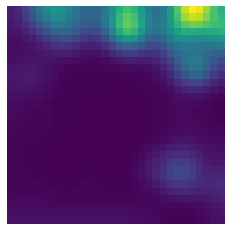

146


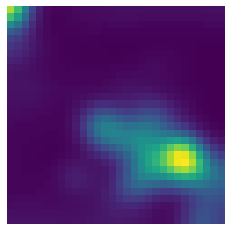

168


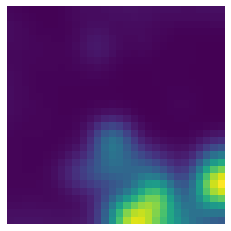

175


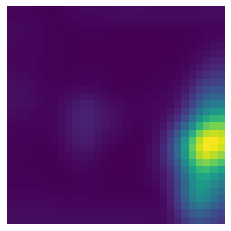

1 10
56


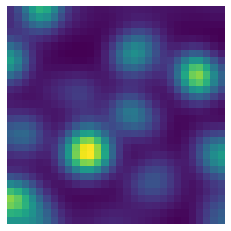

61


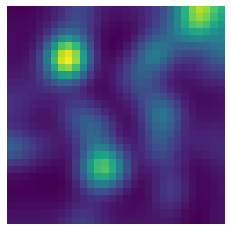

75


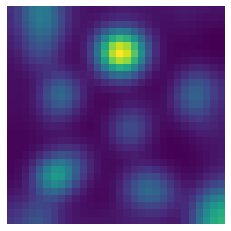

126


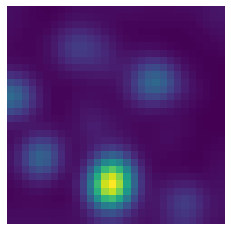

135


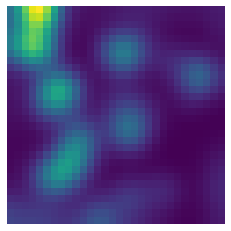

163


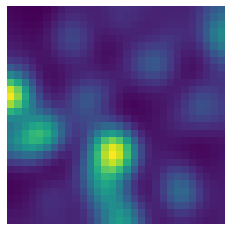

2 11
17


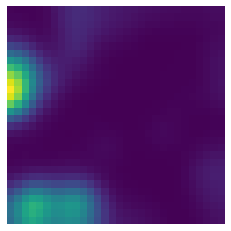

28


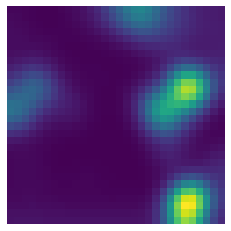

71


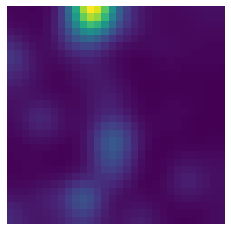

106


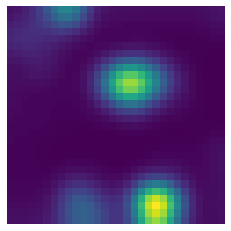

125


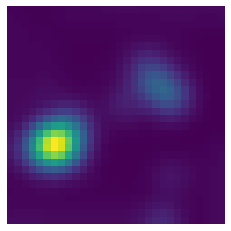

142


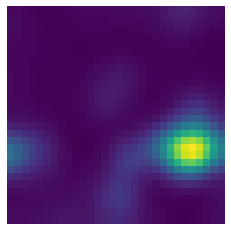

165


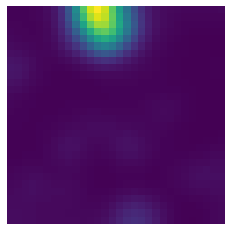

190


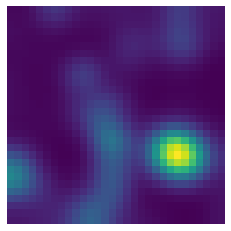

3 2
55


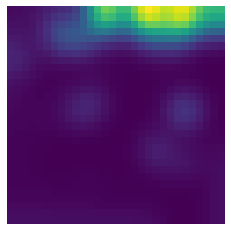

213


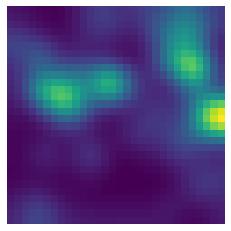

4 2
156


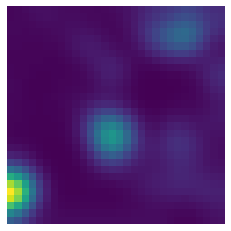

164


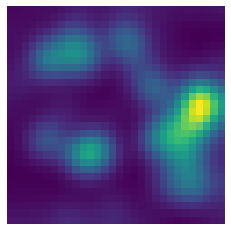

5 113
14


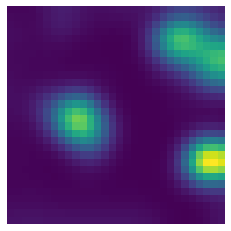

54


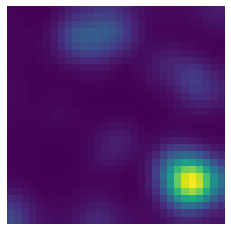

59


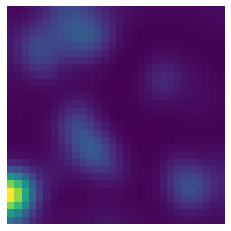

103


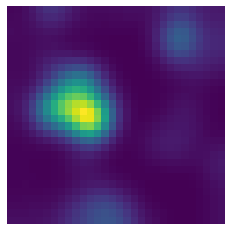

116


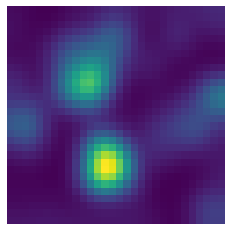

120


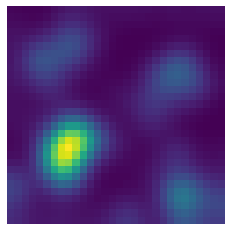

151


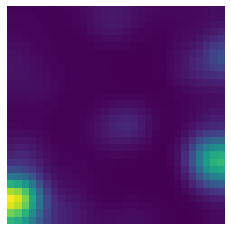

162


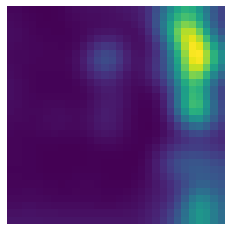

6 4
82


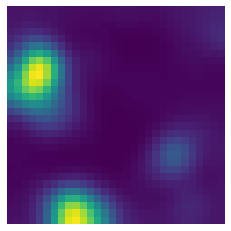

170


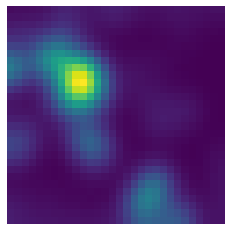

185


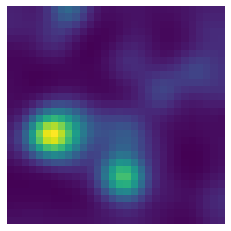

7 4
133


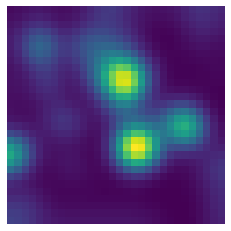

141


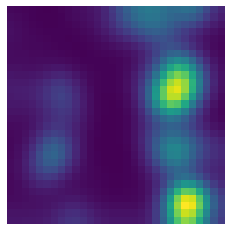

152


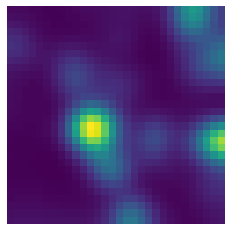

182


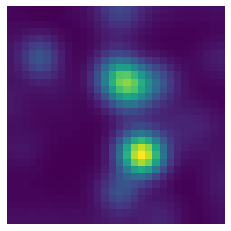

8 2
91


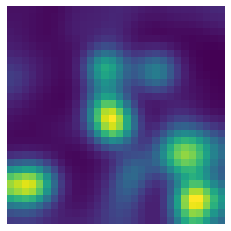

207


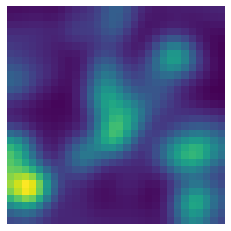

9 2
129


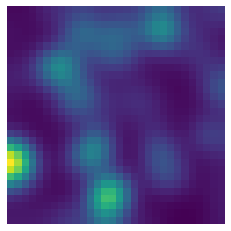

212


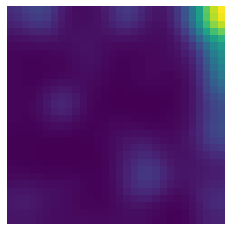

10 10
93


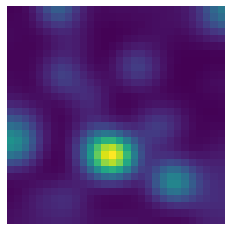

101


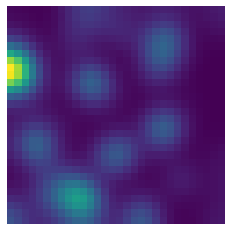

105


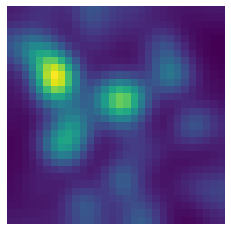

107


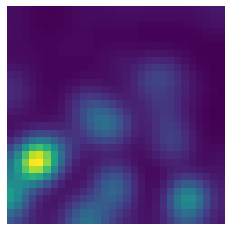

150


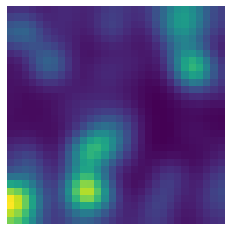

154


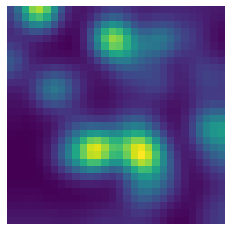

11 1
211


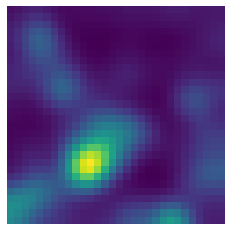

12 4
16


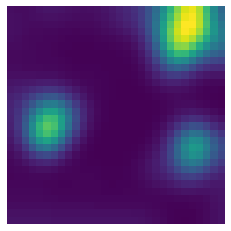

202


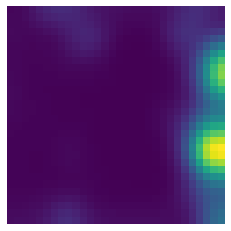

204


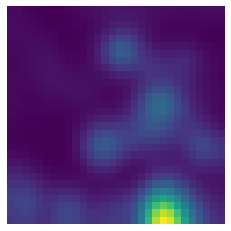

13 3
46


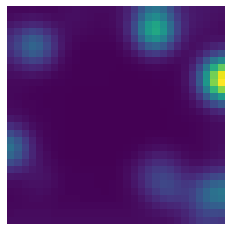

158


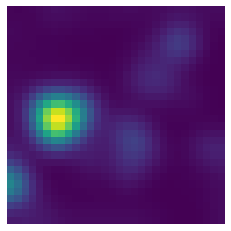

188


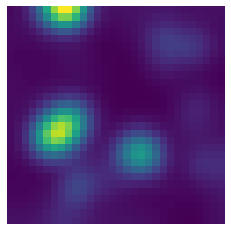

14 1
187


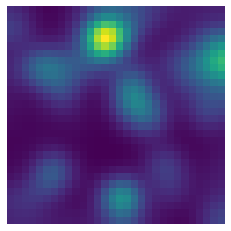

15 5
24


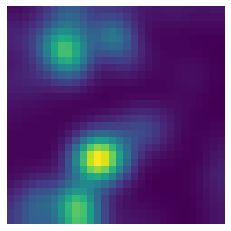

47


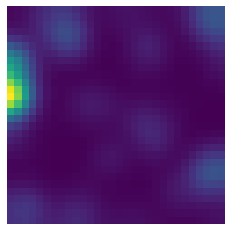

62


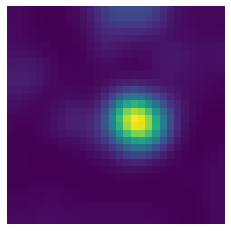

191


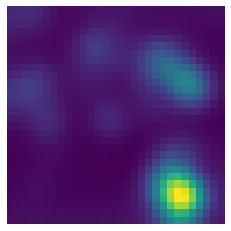

16 1
201


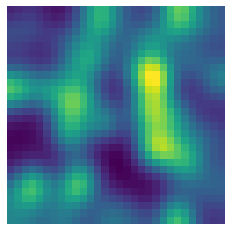

17 1
192


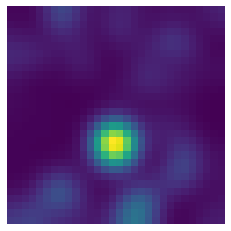

18 1
197


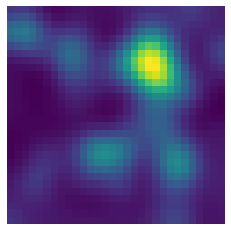

19 4
2


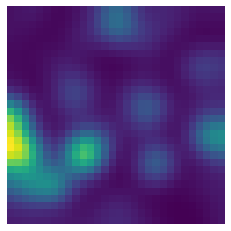

58


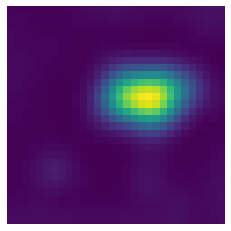

153


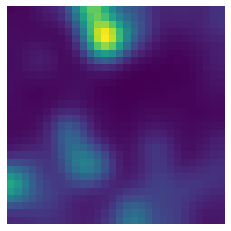

194


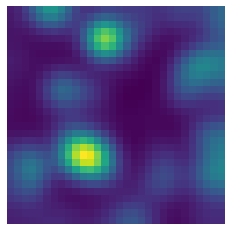

20 1
108


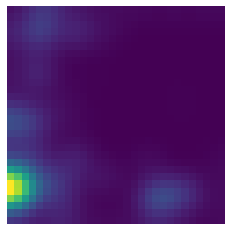

21 2
11


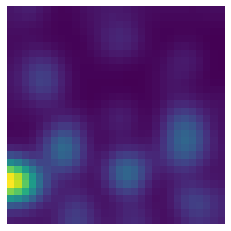

45


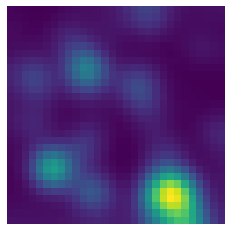

22 12
15


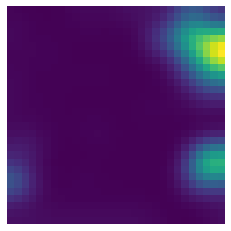

32


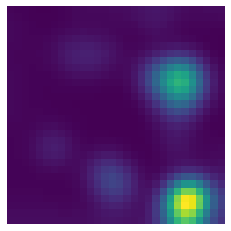

37


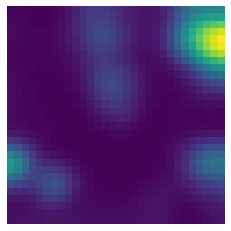

51


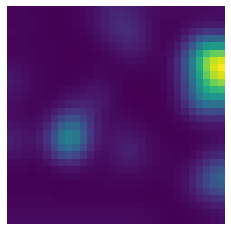

148


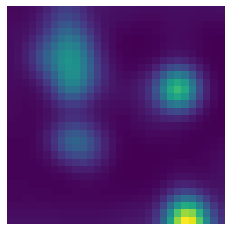

167


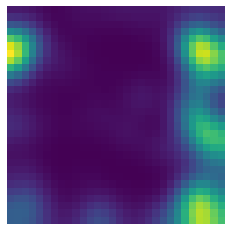

174


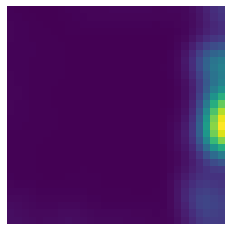

177


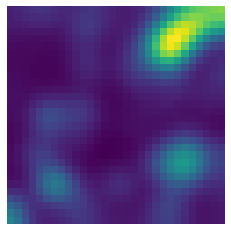

189


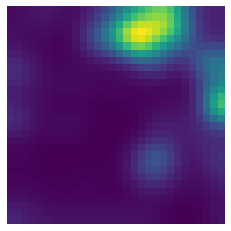

23 1
171


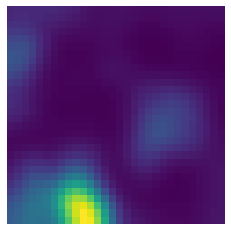

24 1
157


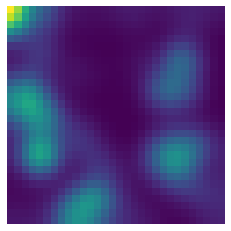

25 1
138


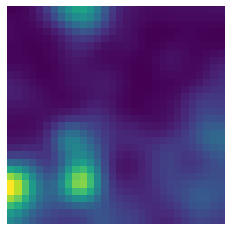

26 3
80


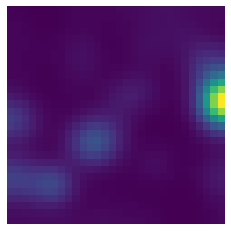

203


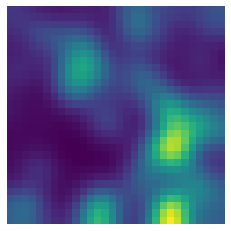

214


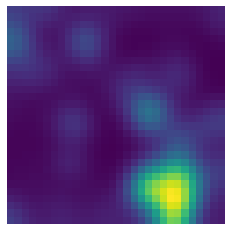

27 2
180


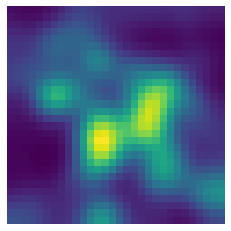

184


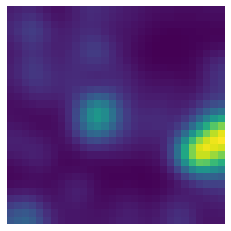

28 3
98


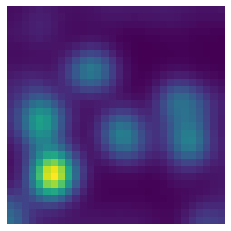

130


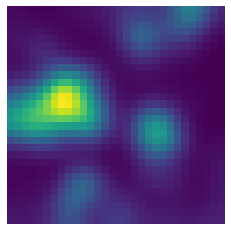

176


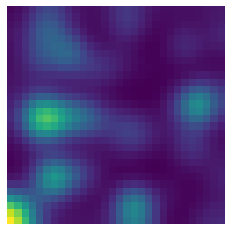

In [15]:
tcurr = 0
tmax = len(spikes0[0,:])
times = np.round(np.linspace(0, len(xx0)-1, tmax)).astype(int)
times1 = np.arange(tcurr, tcurr+tmax)

for i in np.unique(ind):
    if sum(ind==i)>0:
        print(i, sum(ind==i))
        for j in np.where(ind==i)[0][np.unique(np.random.randint(sum(ind==i), size = 10))]:
            print(j)
            fig, axs = plt.subplots(1,1)
            mtot  = binned_statistic_2d(xx0[times],yy0[times],
                                        spikes0[filtered_bool & gs_bool & MEC_bool,:][gs[filtered_bool & gs_bool & MEC_bool]>thr][j, times1], 
                                        bins = 30)[0]

            nans = np.isnan(mtot)
            mtot[nans] = np.mean(mtot[~nans])
            mtot = gaussian_filter(mtot, 2)
            plt.viridis()
            axs.imshow(mtot)
            axs.axis('off')
            axs.set_aspect(1/axs.get_data_ratio())

            plt.show()



<Figure size 432x288 with 0 Axes>

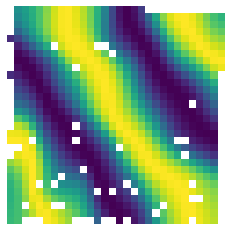

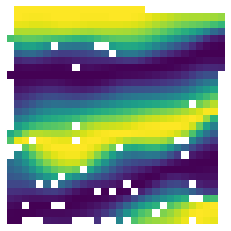

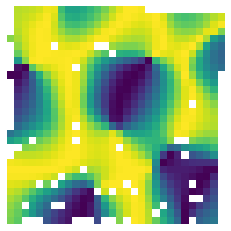

In [18]:
xy_all = {}
movetimes_all = {}
spk_all = {}
coords_all = {}

sp = 100
ii = 5
sig = 2
k = 1000
dim = 6
maxdim = 1
sig1 = 2
sig2 = 0
bSqrt = True
eps = 0.7
npoints = 1000
nbs = npoints
xx,yy, spk, speed_all, sess_name = (xx0, yy0, spikes0, speed0, sess_name0)
print('eps', sess_name)
tsname = Session[Session['session_name']==sess_name]['timeseries_name']
tsname = np.array(tsname)[0]
indscurr = np.where(filtered_bool & gs_bool & MEC_bool)[0][gs[filtered_bool & gs_bool & MEC_bool]>thr][ind == ii]
sspikes = spk[indscurr,:].T
sspikes[np.isnan(sspikes)] = 0
spksum = np.mean(sspikes,0)
indssort = np.where((spksum>0))[0]
times = np.round(np.linspace(0, len(speed_all)-1, len(sspikes))).astype(int)
movetimes0 = np.where((speed_all[times]>sp))[0]  
if sig>0:
    sspk1 = gaussian_filter1d(sspikes[:,indssort],sigma = sig, axis = 0)[movetimes0,:]
else:
    sspk1 = sspikes[movetimes0,:][:,indssort]
if bSqrt:
    sspk1 = np.sqrt(sspk1)
spknull = np.sum(sspk1,1)>0
sspk1 = sspk1[spknull,:]
movetimes0 = movetimes0[spknull]

indstemp = []
dgms, rips_real, indstemp, movetimes1, var_exp = get_dgms(sspk1,
                                                          maxdim = maxdim, k = k, n_points = npoints, 
                                                          dim =dim, nbs = nbs, eps = eps, indstemp = indstemp)
print(len(movetimes1))
np.savez('Functional/' + sess_name + tsname + '_d', d = rips_real['dperm2all'])


fig = plot_barcode(dgms[0])
fig,ax = plt.subplots(1,1)
ax.plot(var_exp[:15], lw = 2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

coords_ds =  get_coords_ds(rips_real, len(indstemp), ph_classes = [0,1,2], 
                              dec_thresh = 0.99, coeff = 47)
plt.figure()
plt.plot(coords_ds[0,np.argsort(indstemp)])
plt.figure()
plt.plot(coords_ds[1,np.argsort(indstemp)])
plt.show()
plt.plot(coords_ds[2,np.argsort(indstemp)])
plt.show()

coords_mod1 = get_coords_all(sspk1, coords_ds, 
                             np.arange(len(sspk1[:,0])),                             
                             indstemp, dim = dim, bPred = False, bPCA = True,
                            spk2 = np.sqrt(gaussian_filter1d(spikes0[indscurr[indssort],:].T, sigma = 2, axis = 0)))
times = np.round(np.linspace(0, len(xx)-1, len(sspikes))).astype(int)
headpos = np.concatenate((xx[:, np.newaxis], 
                          yy[:, np.newaxis]),1)[times,:]#[movetimes0,:]

np.savez('Functional/' + sess_name + '_' + 'decoding_data', indstemp = indstemp, coords_ds = coords_ds)
coords_all[sess_name] = coords_mod1.copy()
xy_all[sess_name] = headpos.copy()
movetimes_all[sess_name] = movetimes0.copy()
spk_all[sess_name] = sspk1.copy()
plt.viridis()
for c in [0,1,2]:
    fig, axs = plt.subplots(1,1)
    nans0 = ~np.isnan(coords_mod1[:,c])
    mtot, __, __, circ = binned_statistic_2d(headpos[:,0][nans0], 
                                             headpos[:,1][nans0],
                                             coords_mod1[:,c][nans0], 
                                             statistic = circmean, bins = 30,
                                             expand_binnumbers = True)

    nans = np.isnan(mtot)
    sintot = np.sin(mtot)
    costot = np.cos(mtot)
    sintot[nans] = np.mean(sintot[~nans])
    costot[nans] = np.mean(costot[~nans])
    sintot = gaussian_filter(sintot,sig1)
    costot = gaussian_filter(costot,sig1)
    mtot = np.cos(np.arctan2(sintot, costot))
    if sig2 > 0:
        mtot = gaussian_filter(mtot, sig2)
    plt.viridis()
    mtot[nans] = np.nan
    axs.imshow(np.rot90(mtot,1))
    axs.axis('off')
    axs.set_aspect(1/axs.get_data_ratio())
    fig.savefig('Figs/Functional/' + sess_name + tsname + '_stripes' + str(c) + '.png', transparent = True)
    fig.savefig('Figs/Functional/' + sess_name + tsname + '_stripes' + str(c) + '.pdf', transparent = True)
plt.show()



eps 26fd0fbe1e205255
17.460278225227178 17.393218283125066


C:\Users\Finnern\AppData\Local\Temp/ipykernel_9480/1920035879.py:246: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


1740
0
infinity 2.7819443702697755
infinity 2.7819443702697755


C:\Users\Finnern\AppData\Local\Temp/ipykernel_9480/1920035879.py:76: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_9480/1920035879.py:77: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


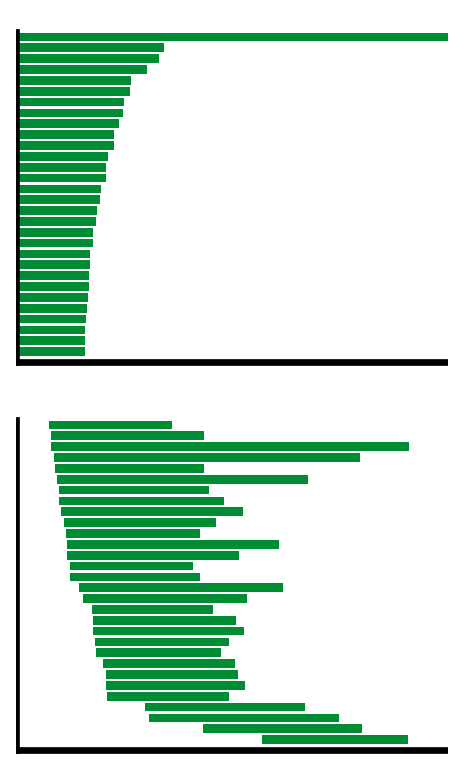

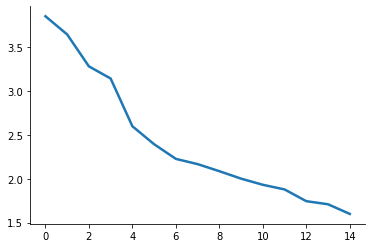

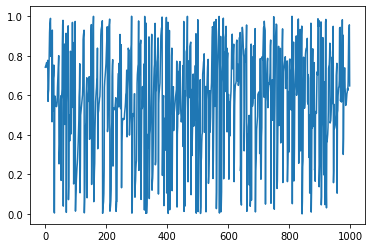

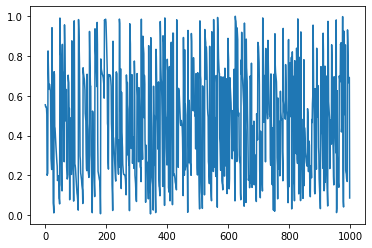

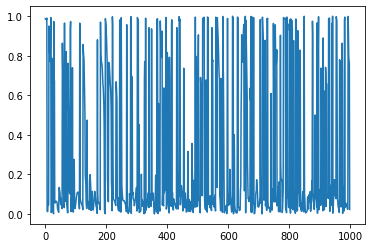

<Figure size 432x288 with 0 Axes>

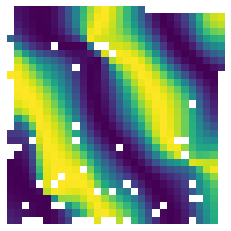

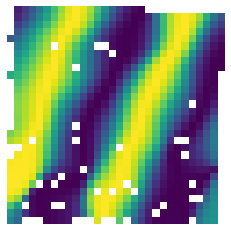

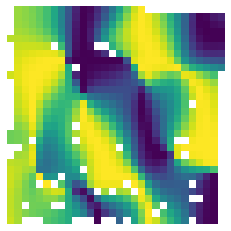

In [19]:
sp = 0
sig = 2
k = 1000
dim = 6
maxdim = 1
sig1 = 2
sig2 = 0
bSqrt = True
npoints = 1000
sp = 100
eps = 0.7
nbs = npoints
xx,yy, spk, speed_all, sess_name = (xx0, yy0, spikes1, speed, sess_name1)
print('eps', sess_name)
tsname = Session[Session['session_name']==sess_name]['timeseries_name']
tsname = np.array(tsname)[0]
sspikes = spk[indscurr,:].T
sspikes[np.isnan(sspikes)] = 0
spksum = np.mean(sspikes,0)
indssort = np.where((spksum>0))[0]

times = np.round(np.linspace(0, len(speed_all)-1, len(sspikes))).astype(int)
movetimes0 = np.where((speed_all[times]>sp))[0]  

if sig>0:
    sspk1 = gaussian_filter1d(sspikes[:,indssort],sigma = sig, axis = 0)[movetimes0,:]
    spk2 = gaussian_filter1d(spikes0[indscurr[indssort],:].T, 
                         sigma = sig, axis = 0)
else:
    sspk1 = sspikes[movetimes0,:][:,indssort]
    spk2 = spikes0[indscurr[indssort],:].T


if bSqrt:
    sspk1 = np.sqrt(sspk1)
    spk2 = np.sqrt(spk2)


spknull = np.sum(sspk1,1)>0
sspk1 = sspk1[spknull,:]

movetimes0 = movetimes0[spknull]


indstemp = []
movetimes1 = []
dgms, rips_real, indstemp, movetimes1, var_exp = get_dgms(sspk1,
                                                          maxdim = maxdim, k = k, n_points = npoints, 
                                                          dim =dim, nbs = nbs, eps = eps, 
                                                          indstemp = indstemp, movetimes1 = movetimes1)
print(len(movetimes1))
np.savez('Functional/'+ sess_name + tsname + '_d', d = rips_real['dperm2all'])


fig = plot_barcode(dgms[0])
fig,ax = plt.subplots(1,1)
ax.plot(var_exp[:15], lw = 2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

coords_ds =  get_coords_ds(rips_real, len(indstemp), ph_classes = [0,1,2], 
                              dec_thresh = 0.99, coeff = 47)
plt.figure()
plt.plot(coords_ds[0,np.argsort(indstemp)])
plt.figure()
plt.plot(coords_ds[1,np.argsort(indstemp)])
plt.show()
plt.plot(coords_ds[2,np.argsort(indstemp)])
plt.show()

coords_mod1 = get_coords_all(sspk1, coords_ds, 
                             np.arange(len(sspk1[:,0])),                             
                             indstemp, dim = dim, bPred = False, bPCA = True,
                            spk2 = spk2
                            )
coords_mod2 = get_coords_all(sspk1, coords_ds, 
                             np.arange(len(sspk1[:,0])),                             
                             indstemp, dim = dim, bPred = False, bPCA = True,
                            spk2 = np.sqrt(gaussian_filter1d(spikes1[indscurr[indssort],:].T, sigma = 2, axis = 0)))

np.savez('Functional/' + sess_name + '_' + 'decoding_data', indstemp = indstemp, coords_ds = coords_ds)
coords_all[sess_name + '_OF'] = coords_mod1.copy()
coords_all[sess_name] = coords_mod2.copy()
xy_all[sess_name ] = pos1[times].copy()
movetimes_all[sess_name] = movetimes0.copy()
spk_all[sess_name] = sspk1.copy()


times = np.round(np.linspace(0, len(xx)-1, len(spk2))).astype(int)
headpos = np.concatenate((xx[:, np.newaxis], 
                          yy[:, np.newaxis]),1)[times,:]

xy_all[sess_name + '_OF'] = headpos.copy()
plt.viridis()
for c in [0,1,2]:
    fig, axs = plt.subplots(1,1)
    nans0 = ~np.isnan(coords_mod1[:,c])
    mtot, __, __, circ = binned_statistic_2d(headpos[:,0][nans0], 
                                             headpos[:,1][nans0],
                                             coords_mod1[:,c][nans0], 
                                             statistic = circmean, bins = 30,
                                             expand_binnumbers = True)

    nans = np.isnan(mtot)
    sintot = np.sin(mtot)
    costot = np.cos(mtot)
    sintot[nans] = np.mean(sintot[~nans])
    costot[nans] = np.mean(costot[~nans])
    sintot = gaussian_filter(sintot,sig1)
    costot = gaussian_filter(costot,sig1)
    mtot = np.cos(np.arctan2(sintot, costot))
    if sig2 > 0:
        mtot = gaussian_filter(mtot, sig2)
    plt.viridis()
    mtot[nans] = np.nan
    axs.imshow(np.rot90(mtot,1))
    axs.axis('off')
    axs.set_aspect(1/axs.get_data_ratio())
    fig.savefig('Figs/Functional/' + sess_name + tsname + '_stripes' + str(c) + '.png', transparent = True)
    fig.savefig('Figs/Functional/' + sess_name + tsname + '_stripes' + str(c) + '.pdf', transparent = True)
plt.show()


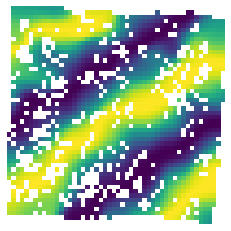

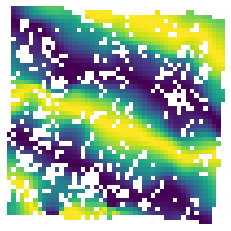

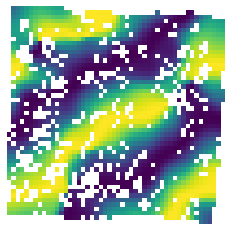

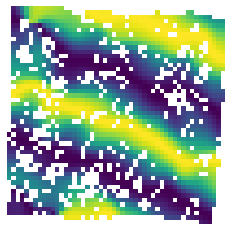

In [20]:
coords_aligned = {}
for it ,sess in enumerate([sess_name0, sess_name1]):
    tsname = Session[Session['session_name']==sess]['timeseries_name']
    tsname = np.array(tsname)[0]

    if it == 1:        
        coords_mod1 = coords_all[sess + '_OF'].copy()
        headpos = xy_all[sess + '_OF'].copy()
        coords_mod1[:,0] = 2*np.pi-coords_mod1[:,0]
        
        coords_mod2 = coords_all[sess].copy()
        coords_mod2[:,0] = 2*np.pi-coords_mod2[:,0]
        dtheta = np.arctan2(np.mean(np.sin(coords_mod1 - coords_aligned[sess_name0]),axis = 0),
                           np.mean(np.cos(coords_mod1 - coords_aligned[sess_name0]),axis = 0))
        coords_mod1-= dtheta
        coords_mod2-= dtheta
        coords_mod1 = coords_mod1%(2*np.pi)
        coords_mod2 = coords_mod2%(2*np.pi)
    else:
        coords_mod1 = coords_all[sess].copy()
        headpos = xy_all[sess].copy()
        movetimes0 = movetimes_all[sess].copy()
        coords_mod1[:,1] += 2/np.sqrt(3)*coords_mod1[:,0]
        coords_mod1[:,1] = 2*np.pi-coords_mod1[:,1]
        coords_mod1 = coords_mod1%(2*np.pi)
    if it == 1:        
        coords_aligned[sess + '_OF'] = coords_mod1.copy()    
        coords_aligned[sess] = coords_mod2.copy()    
    else:    
        coords_aligned[sess] = coords_mod1.copy()
    
    for c in [0,1,]:
        fig, axs = plt.subplots(1,1)
        nans0 = ~np.isnan(coords_mod1[:,c])
        mtot, __, __, circ  = binned_statistic_2d(headpos[:,0][nans0],
                                                  headpos[:,1][nans0],
                                                  coords_mod1[:,c][nans0], 
                                                  statistic = circmean, 
                                                  bins = 50,
                                                  expand_binnumbers = True)

        nans = np.isnan(mtot)
        sintot = np.sin(mtot)
        costot = np.cos(mtot)
        sintot[nans] = np.mean(sintot[~nans])
        costot[nans] = np.mean(costot[~nans])
        sintot = gaussian_filter(sintot,sig)
        costot = gaussian_filter(costot,sig)
        mtot = np.cos(np.arctan2(sintot, costot))
#            mtot = gaussian_filter(mtot, 1)
        plt.viridis()
        mtot[nans] = np.nan
        axs.imshow(mtot)
        axs.axis('off')
        axs.set_aspect(1/axs.get_data_ratio())
        fig.savefig('Figs/Functional/' + sess + tsname + '_stripes' + str(c) + '.png', transparent = True)
        fig.savefig('Figs/Functional/'+ sess  + tsname + '_stripes' + str(c) + '.pdf', transparent = True)
    plt.show()


In [ ]:
from matplotlib.collections import PathCollection
import cv2 as cv
numbins1 = 30
sig1 = 2
roll = 3
sess_both = sess_name0 +sess_name1
#os.mkdir('Figs/Functional/' + sess_both)
plt.viridis()
for it,  n in enumerate(range(num_neurons)):
    fig, axs = plt.subplots(1,4)
    for sess_it, sess in enumerate([sess_name0, sess_name1]):
        sspk1 = spk_all[sess].copy()
        headpos = xy_all[sess].copy()
        num_neurons = len(sspk1[0,:])
        pp = coords_aligned[sess].copy()%(2*np.pi)


        movetimes0 = movetimes_all[sess].copy()


        if sess_it == 0:
            mtot_tmp, x_edge, y_edge,c2 = binned_statistic_2d(headpos[:,0], headpos[:,1],
                                          sspk1[:,n], statistic='mean', 
                                         bins=numbins1, range=None, expand_binnumbers=True)


            nans = np.isnan(mtot_tmp)
            mtot_tmp[np.isnan(mtot_tmp)] = np.mean(mtot_tmp[~np.isnan(mtot_tmp)])
            nans = np.isnan(mtot_tmp)
            mtot_tmp[nans] = np.mean(mtot_tmp[~nans])
            mtot_tmp = gaussian_filter(mtot_tmp,sigma = sig1)
            mtot_tmp[nans] = np.nan

            ax = axs[sess_it]
            ax.imshow(mtot_tmp, origin = 'lower', extent = [0,2*np.pi,0, 2*np.pi], vmin = 0, vmax = np.max(mtot_tmp) *0.975)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            #posx_trial = pos + (pos_trial-1)*400
            times = np.round(np.linspace(0, len(pos)-1, 9000)).astype(int)
            posx = pos[times][movetimes0]
            binsx = np.linspace(0,np.max(posx)+1e-3, int(np.max(posx)/10))
            spk = binned_statistic(posx, sspk1[:,n], bins = binsx)[0]
            lencorr = 500
            spk[np.isnan(spk)] = 0
            acorrs = np.zeros(lencorr)

            spktemp = np.concatenate((spk, np.zeros(lencorr)))
            lenspk = len(spk)
            for t1 in range(lencorr):
                acorrs[t1] = np.sum(np.dot(spk,np.roll(spktemp, t1)[:lenspk]))
            acorrs /= acorrs[0]

            ax = axs[sess_it]
            ax.bar(np.arange(lencorr), acorrs, width = 1, color = 'k')
            ax.set_xlim([0,lencorr])
            ax.set_ylim([0, 0.1])
            ax.set_xticks([0, 250, lencorr])
            ax.set_yticks([0.0, 0.05, 0.1])
            ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_aspect(1/ax.get_data_ratio())

        mtot_tmp, x_edge, y_edge,c2 = binned_statistic_2d(pp[:,0], pp[:,1],
                                              sspk1[:,n], statistic='mean', 
                                             bins=numbins1, range=None, expand_binnumbers=True)
        nans = np.isnan(mtot_tmp)
        mtot_tmp[np.isnan(mtot_tmp)] = np.mean(mtot_tmp[~np.isnan(mtot_tmp)])
        mtot_tmp = smooth_tuning_map(np.rot90(mtot_tmp,1), numbins1+1, sig1, bClose = True) 
#        mtot_tmp[nans] = -np.inf
        ax = axs[sess_it+2]
        ax.imshow(mtot_tmp, origin = 'lower', extent = [0,2*np.pi,0, 2*np.pi], 
                  vmin = 0, vmax = np.max(mtot_tmp[~np.isnan(mtot_tmp)]) *0.975)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(1/ax.get_data_ratio())
        r_box = transforms.Affine2D().skew_deg(15,15)

        for x in ax.images + ax.lines + ax.collections:
            trans = x.get_transform()
            x.set_transform(r_box+trans) 
            if isinstance(x, PathCollection):
                transoff = x.get_offset_transform()
                x._transOffset = r_box+transoff     
        ax.set_xlim(0, 2*np.pi + 3*np.pi/5)
        ax.set_ylim(0, 2*np.pi + 3*np.pi/5)
        ax.set_aspect('equal', 'box') 
        ax.axis('off')   
#    plt.show()
        fig.savefig('Figs/Functional/' +  sess_both + '/toroidal_ratemap' + str(it) + '.png', transparent = True, pad_inches = 0.1)
        fig.savefig('Figs/Functional/'  + sess_both + '/toroidal_ratemap' + str(it) + '.pdf', transparent = True, pad_inches = 0.1)
        plt.close()

<Figure size 432x288 with 0 Axes>

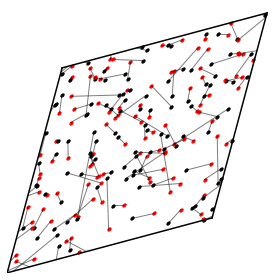

<Figure size 432x288 with 0 Axes>

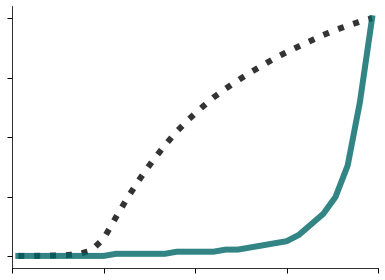

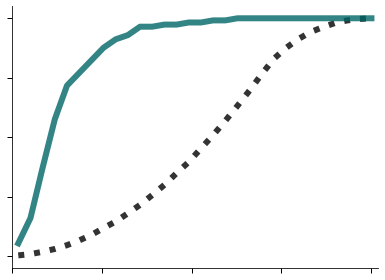

In [23]:
numangsint = 16
numangsint_1 = numangsint-1
bins = np.linspace(0,2*np.pi, numangsint)
xv, yv = np.meshgrid(bins[0:-1] + (bins[1:] -bins[:-1])/2, 
                bins[0:-1] + (bins[1:] -bins[:-1])/2)
pos  = np.concatenate((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis]),1)
ccos = np.cos(pos)
csin = np.sin(pos)
mtots =  {}
mcs = {}
t0 = 0
for it, sess in enumerate([sess_name0, sess_name1]):
    cc1 = coords_aligned[sess].copy()
    currspk = spk_all[sess].copy()
    
    if it == 0:
        sspk1 = spikes0[indscurr[indssort],:].T
    else:
        sspk1 = spikes1[indscurr[indssort],:].T
#    sspk1 = np.sqrt(gaussian_filter1d(sspk1, axis = 0, sigma = 2))    
    num_neurons = len(sspk1[0,:])
    mcs[sess] = np.zeros((num_neurons,2))
    mtots[sess] = np.zeros((num_neurons, numangsint_1, numangsint_1))
    for n in range(num_neurons):
        mtot_tmp, x_edge, y_edge,c2 = binned_statistic_2d(cc1[:,0],cc1[:,1], 
                                             sspk1[:,n], statistic='mean', 
                                             bins=bins, range=None, expand_binnumbers=True)
        mtots[sess][n, :, :] = mtot_tmp.copy()
        nans = np.isnan(mtot_tmp)
#        mtot_tmp[nans] = 0
#        mtot_tmp = smooth_tuning_map(mtot_tmp, numangsint, sig = 5, bClose = False)
#        mtot_tmp[nans] = np.nan
        mtot_tmp1 = mtot_tmp.flatten()
        nans  = ~np.isnan(mtot_tmp1) 
        centcos = np.sum(np.multiply(ccos[nans,:],mtot_tmp1[nans,np.newaxis]),0)
        centsin = np.sum(np.multiply(csin[nans,:],mtot_tmp1[nans,np.newaxis]),0)
        mcs[sess][n,:] = np.arctan2(centsin,centcos)%(2*np.pi)

plt.figure()
plot_phase_distribution(mcs[sess_name0], mcs[sess_name1], )
plt.tight_layout()
plt.savefig(sess_name0 +  '_' + sess_name1 + '_phases.png', transparent = True, pad_inches = 0.1)
plt.savefig(sess_name0 +  '_' + sess_name1 + '_phases.pdf', transparent = True, pad_inches = 0.1)


corr, dist, corr_shuffle, dist_shuffle = get_corr_dist(mcs[sess_name0], mcs[sess_name1], 
                                              mtots[sess_name0], mtots[sess_name1])
plt.figure()
plot_cumulative_stat(corr, corr_shuffle, (-1,1), 1, 
            [-1, -0.5, 0.0, 0.5, 1.0], [0.0, 0.25, 0.5, 0.75, 1.0], [-1,1], [-0.05,1.05])
plt.tight_layout()
plt.savefig(sess_name0 +  '_' + sess_name1 + '_corr_cumsum.png', transparent = True, pad_inches = 0.1)
plt.savefig(sess_name0 +  '_' + sess_name1 + '_corr_cumsum.pdf', transparent = True, pad_inches = 0.1)

plot_cumulative_stat(dist, dist_shuffle, (0,np.sqrt(2)*np.pi), 180/np.pi, 
            [0, 62.5, 125, 187.5, 250], [0.0, 0.25, 0.5, 0.75, 1.0], [0,255], [-0.05,1.05])
plt.tight_layout()
plt.savefig(sess_name0 +  '_' + sess_name1 + '_dist_cumsum.png', transparent = True, pad_inches = 0.1)
plt.savefig(sess_name0 +  '_' + sess_name1 + '_dist_cumsum.pdf', transparent = True, pad_inches = 0.1)



In [25]:
np.savez('W2_phases', corr = corr, dist = dist, corr_shuffle = corr_shuffle, dist_shuffle = dist_shuffle,
         mcs = mcs)